In [1]:
import xarray as xr
import numpy as np
from math import pi
import datetime as dt
import os
import sys
from pathlib import Path
from os.path import exists
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
#from pathlib import Path
from datetime import *; from dateutil.relativedelta import *
#from scipy.interpolate import make_interp_spline, BSpline
#from scipy.signal import savgol_filter
%matplotlib inline
sys.path.append('./subroutines/')
from read_gridded_data import get_monthly_data


boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2','CalCur1','CalCur3']

def get_center_kathleen(rlon):
    if rlon==-165:
        ds_lon = xr.open_dataset('F:/data/NASA_biophysical/timeseries_data/MonthlyBifurcationLat165.nc')
    if rlon==-135:
        ds_lon = xr.open_dataset('F:/data/NASA_biophysical/timeseries_data/MonthlyBifurcationLat135.nc')
    ds_lon['month']=np.ceil((ds_lon.year-ds_lon.year.astype('int'))*12).astype('int')
    ds_lon['iyear']=ds_lon.year.astype('int')
    ds_lon = ds_lon.assign_coords(yr=ds_lon.year)
    ds_lon = ds_lon.assign_coords(iyear=ds_lon.iyear)
    ds_lon = ds_lon.assign_coords(month=ds_lon.month)
    ds_out = ds_lon.copy(deep=True)    
    tt=[]
    for i in range(276):
        dtem=np.datetime64(str(ds_out.iyear[i].data)+'-'+str(ds_out.month[i].data).zfill(2))
        tt.append(dtem)
    ds_lon.close()
    ds_out['yr']=tt
    return ds_out
def get_center_chelle(rlon):
    adir_data='F:/data/NASA_biophysical/biforcation_figures_chelle/'
    if rlon==-165:
        ds=xr.open_dataset(adir_data+'biforcation_data165_monthly_aviso.nc')
    if rlon==-135:
        ds=xr.open_dataset(adir_data+'biforcation_data135_monthly_aviso.nc')
    ds.close()
    return ds


#trying to get into xarray properly
location_values = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2','NPC-var','NPC-bi-var','CalCur1','CalCur3']
data = [-160,-130,-120,-130,-148,-160,-130,-122,-116]
lon1 = xr.DataArray(data, coords=[location_values], dims=['location'])
data = [-170,-140,-130,-140,-158,-170,-140,-132,-126]
lon2 = xr.DataArray(data, coords=[location_values], dims=['location'])
data = [43.5,48.5,37.5,54.6,54.5,43.5,48.5,42.5,32.5]
lat1 = xr.DataArray(data, coords=[location_values], dims=['location'])
data = [46,51,40,57,57,46,51,45,35]
lat2 = xr.DataArray(data, coords=[location_values], dims=['location'])
boxes = xr.Dataset({'lon_min':lon1,'lon_max':lon2,'lat_cen':lat1})

def get_mask():
    filelist=[]
    dir_data = 'F:/data/sst/cmc/CMC0.2deg/v2/data/'
    for filename in Path(dir_data).rglob('*CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'):
        filelist.append(filename)
    ds=xr.open_dataset(filelist[0])
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180)).sortby('lon').sortby('lat')
    ds = ds.resample(time='M',keep_attrs=True).mean(skipna=False,keep_attrs=True)
    mask=ds.mask.where(ds.mask[0,:,:]==1)
    mask=mask[0,:,:].drop('time')
    return mask


def subset_data(ds_tem,ireg,boxes):
    if (ireg<5) or (ireg>6):
        tem = ds_tem.sel(lon=slice(boxes.lon_max[ireg],boxes.lon_min[ireg]),
                         lat=slice((boxes.lat_cen[ireg]-2.5),(boxes.lat_cen[ireg]+2.5)))
        ds_mean = tem.mean({'lat','lon'},keep_attrs=True)
    else:
        if ireg==5:
            rlon=-165
        if ireg==6:
            rlon=-135
        boxes_cen = get_center_chelle(rlon)
        datasets=[]
        for tinc in ds_tem.time:
            cen_lat=boxes_cen.lat.sel(time=tinc,method='nearest').data
#            cen_lat=boxes_cen.latitude.sel(yr=tinc,method='nearest').data
            tem=ds_tem.sel(time=tinc,
                           lon=slice(rlon-5,rlon+5),
                           lat=slice(cen_lat-2.5,cen_lat+2.5))
            mn_new = tem.mean({'lat','lon'},keep_attrs=True)
            datasets.append(mn_new)
        ds_mean = xr.concat(datasets, dim='time')
        ds_mean.load()
    return ds_mean

In [6]:
dir_timeseries='F:/data/NASA_biophysical/timeseries_data/'
date_start,date_end,date_end2='1993-01-01','2018-12-31','2019-10-31'
darray = ['oscar','godas_mld','ccmp','cmc_sst','cmem_sss','aviso']
mask=get_mask()

for itype in range(1,2):
#    if itype==1:
#        continue
    print(itype)
    dtype = darray[itype]
    print('getting data:',dtype)
    #v6 uses groupby instead of creating climatology first
    ds= get_monthly_data(dtype)
    mask2=mask.interp(lat=ds.lat,lon=ds.lon,method='nearest')
    ds.coords['mask']=mask2
    ds=ds.where(ds.mask==1)

    ds=ds.sel(time=slice(date_start,date_end2))
    ds_tem=ds #.sel(time=slice(date_start,date_end))
    print('got data',itype)
    #now iterate over regions
    for i in range(0,9):
        print(i)
        #create climatology over shorter period
        #for boxes 5 and 6 this method won't work because the area is moving
        if (i<5) or (i>6):
            ds_mean = subset_data(ds_tem,i,boxes)
            ds_mean_tem=ds_mean.sel(time=slice(date_start,date_end))
            data_climatology = ds_mean_tem.groupby('time.month').mean('time',keep_attrs=True,skipna=False)
            data_anomaly = ds_mean.groupby('time.month') - data_climatology
            ds_anom=data_anomaly
        else:
            if i==5:
                ds_mean_tem=ds_tem.sel(time=slice(date_start,date_end))
                data_climatology = ds_mean_tem.groupby('time.month').mean('time',keep_attrs=True,skipna=False)
                data_anomaly = ds.groupby('time.month') - data_climatology            
            ds_mean = subset_data(ds_tem,i,boxes)
            ds_anom = subset_data(data_anomaly,i,boxes)           
            
        global_attributes = ds_tem.attrs
        data_anomaly.attrs = global_attributes      
        ds_mean_clim=ds_mean-ds_anom

        if i==0:
            ds_box = ds_mean
            ds_box_clim = ds_mean_clim
            ds_box_anom = ds_anom #ds_mean - ds_mean_clim #ds_anom
        else:
            ds_box = xr.concat([ds_box,ds_mean],dim='box')
            ds_box_clim = xr.concat([ds_box_clim,ds_mean_clim],dim='box')
            ds_box_anom = xr.concat([ds_box_anom,ds_anom],dim='box')
    filename_out = dir_timeseries + dtype + str(date_start)+'data_v6.nc'
    ds_box.to_netcdf(filename_out)
    df = ds_box.to_dataframe()
    filename_out = dir_timeseries + dtype + str(date_start)+'data_v6.csv'
    df.to_csv(filename_out)
    filename_out_clim = dir_timeseries + dtype + str(date_start)+'data_minus_clim_v6.nc'
    ds_box_anom.to_netcdf(filename_out_clim)
    df = ds_box_anom.to_dataframe()
    filename_out = dir_timeseries + dtype +str(date_start)+ 'data_minus_clim_v6.csv'
    df.to_csv(filename_out)
    
    #ds_box_clim=ds_box-ds_box_anom
    filename_out_clim = dir_timeseries + dtype + str(date_start)+'data_clim_v6.nc'
    ds_box_clim.to_netcdf(filename_out_clim)
    df = ds_box_clim.to_dataframe()
    filename_out = dir_timeseries + dtype + str(date_start)+'data_clim_v6.csv'
    df.to_csv(filename_out)


1
getting data: godas_mld
got data 1
0
1
2
3
4
5


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


6


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


7
8


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\dask\core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*args2)


In [36]:
dir_timeseries='F:/data/NASA_biophysical/timeseries_data/'
date_start,date_end,date_end2='1993-01-01','2018-12-31','2019-10-31'
darray = ['oscar','godas_mld','ccmp','cmc_sst','cmem_sss','aviso']
mask=get_mask()

for itype in range(0,1):
    print(itype)
    dtype = darray[itype]
    print('getting data:',dtype)
    #v6 uses groupby instead of creating climatology first
    ds= get_monthly_data(dtype)
    mask2=mask.interp(lat=ds.lat,lon=ds.lon,method='nearest')
    ds.coords['mask']=mask2
    ds=ds.where(ds.mask==1)

    ds=ds.sel(time=slice(date_start,date_end2))
    ds_tem=ds #.sel(time=slice(date_start,date_end))
    print('got data',itype)
    ds.coords['lon'] = np.mod(ds['lon'], 360)
    ds = ds.sortby(ds.lon)
    ds = ds.sel(lat=slice(30,63),lon=slice(180,250))
    ds2 = ds.groupby('time.month').mean()
    ds2 = ds2.load()
#    ds_seasonal = ds.resample(time='QS-DEC',keep_attrs=True).mean(skipna=False)
#    clim = ds_seasonal.groupby(time='season').mean()

0
getting data: oscar
got data 0


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\dask\array\numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


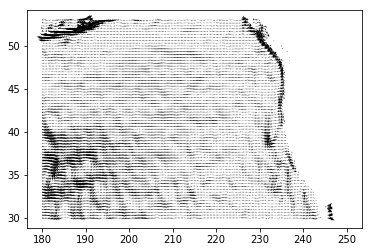

In [35]:
# Combine 1D latitude and longitudes into a 2D grid of locations
lon_2d, lat_2d = np.meshgrid(ds2.lon, ds2.lat)
u_wind=ds2.u[0,:,:]
v_wind=ds2.v[0,:,:]
wind = plt.quiver(lon_2d, lat_2d, u_wind, v_wind)

In [33]:
ds2

<xarray.Dataset>
Dimensions:  (lat: 70, lon: 211, month: 12)
Coordinates:
    mask     (lat, lon) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... nan nan nan nan nan
    depth    float32 15.0
  * lon      (lon) float64 180.0 180.3 180.7 181.0 ... 249.0 249.3 249.7 250.0
  * lat      (lat) float64 30.0 30.33 30.67 31.0 31.33 ... 52.0 52.33 52.67 53.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    u        (month, lat, lon) float64 dask.array<chunksize=(1, 70, 211), meta=np.ndarray>
    v        (month, lat, lon) float64 dask.array<chunksize=(1, 70, 211), meta=np.ndarray>

KeyboardInterrupt: 

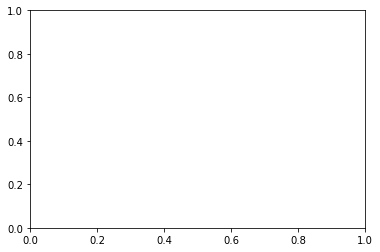

In [5]:
fig, ax = plt.subplots(1, 1,figsize=(12, 12))
for iregion in range(0,1): #5):
    ax[iregion].plot(ds.time[:], ds.spd[iregion,:], linewidth=2, color='blue')
    arrow_scaler = .001
    for i in range(0,len(ds.time),1):
        u = arrow_scaler*ds.u[iregion,i] #-1*np.sin((np.pi/180)*(ds.dir[iregion,i]))
        v = arrow_scaler*ds.v[iregion,i] #-1*np.cos((np.pi/180)*(ds.dir[iregion,i]))
        ax[iregion].quiver(ds.time[i].values,ds.spd[iregion,:].mean(),u.values,v.values,width=0.001)
        ax[iregion].set_ylim(0,.08)
        ax[iregion].set_ylabel(boxes_names[iregion])
fig.savefig(dir_figs + 'timeseries_winds.png', dpi=100)

<xarray.Dataset>
Dimensions:  (lat: 481, lon: 1080, time: 108)
Coordinates:
  * time     (time) datetime64[ns] 1992-12-01 1993-03-01 ... 2019-09-01
    mask     (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    depth    float32 15.0
  * lon      (lon) float64 -180.0 -179.7 -179.3 -179.0 ... 179.0 179.3 179.7
  * lat      (lat) float64 -80.0 -79.67 -79.33 -79.0 ... 79.0 79.33 79.67 80.0
Data variables:
    u        (time, lat, lon) float64 dask.array<chunksize=(1, 481, 1080), meta=np.ndarray>
    v        (time, lat, lon) float64 dask.array<chunksize=(1, 481, 1080), meta=np.ndarray>

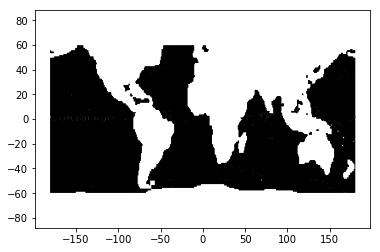

In [ ]:
#plot only anomalies, use variable latitudes
boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2','NPC','NPC-biforcation']
fig, axarr = plt.subplots(7, 5,figsize=(12,14))
#fig.clf()
ax_order = [0,0,2,3,4,0,1]
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp_anom
            ax = axarr[0,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.uwnd, 23, 2)
            ax.plot(ds.time[:],tem.uwnd, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='black',linewidth=2)
            ax.axhline(y=0.0, color='blue', linestyle='-')
            ax.set_title(boxes_names[ax_order[iregion]])
            if iregion==5:
                ax.set_ylabel('$\Delta$East Wind Speed (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-4,4)
        if icol==0:
            ds = ds_ccmp_anom
            ax = axarr[1,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.vwnd, 23, 2)
            ax.plot(ds.time[:],tem.vwnd, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='black',linewidth=2)
            ax.axhline(y=0.0, color='blue', linestyle='-')
            ax.set_title(boxes_names[ax_order[iregion]])
            if iregion==5:
                ax.set_ylabel('$\Delta$East North Speed (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-4,4)
        if icol==0:
            ds = ds_mld_anom
            ax = axarr[2,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.dbss_obml, 23, 2)
            ax.plot(ds.time[:],tem.dbss_obml, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$MLD (m)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-30,30)
        if icol==1:
            ds = ds_sss_anom
            ax = axarr[3,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.so, 23, 2)
            ax.plot(ds.time[:],tem.so, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$SSS (psu)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-.75,.75)
        if icol==2:
            ds = ds_sst_anom
            ax = axarr[4,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.analysed_sst, 23, 2)
            ax.plot(ds.time[:],tem.analysed_sst, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$SST (K)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-4,4)
        if icol==3:
            ds = ds_oscar_anom
            ax = axarr[5,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.u, 23, 2)
            ax.plot(ds.time[:],tem.u, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$East Cur Vel (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
            ax.set_ylim(-0.05,0.05)
        if icol==4:
            #ds = ds_oscar
            ds = ds_oscar_anom
            ax = axarr[6,ax_order[iregion]]
            tem = ds.isel(box=iregion)
#            tem,tem2 = ds.isel(box=iregion),ds2.isel(box=iregion)
            #dif = tem - tem2
            ds_smoothed = savgol_filter(tem.v, 23, 2)
            ax.plot(ds.time[:],tem.v, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$North Cur Vel (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
            ax.set_ylim(-.05,.05)
fig.autofmt_xdate()
fig.savefig(dir_figs + 'timeseries_anomaly_v3.png', dpi=100)

In [ ]:
#plot only anomalies, use variable latitudes
boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2','NPC','NPC-biforcation']
fig, axarr = plt.subplots(7, 5,figsize=(12,14))
#fig.clf()
ax_order = [0,0,2,3,4,0,1]
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp_anom
            ax = axarr[0,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.uwnd, 23, 2)
            #ax.plot(ds.time[:],tem.uwnd, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='black',linewidth=2)
            ax.axhline(y=0.0, color='blue', linestyle='-')
            ax.set_title(boxes_names[ax_order[iregion]])
            if iregion==5:
                ax.set_ylabel('$\Delta$East Wind Speed (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-3,3)
        if icol==0:
            ds = ds_ccmp_anom
            ax = axarr[1,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.vwnd, 23, 2)
            #ax.plot(ds.time[:],tem.vwnd, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='black',linewidth=2)
            ax.axhline(y=0.0, color='blue', linestyle='-')
            ax.set_title(boxes_names[ax_order[iregion]])
            if iregion==5:
                ax.set_ylabel('$\Delta$East North Speed (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-3,3)
        if icol==0:
            ds = ds_mld_anom
            ax = axarr[2,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.dbss_obml, 23, 2)
            #ax.plot(ds.time[:],tem.dbss_obml, label = 'Anomaly',color='red',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$MLD (m)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-30,30)
        if icol==1:
            ds = ds_sss_anom
            ax = axarr[3,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.so, 23, 2)
            #ax.plot(ds.time[:],tem.so, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$SSS (psu)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-.5,.5)
        if icol==2:
            ds = ds_sst_anom
            ax = axarr[4,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.analysed_sst, 23, 2)
            #ax.plot(ds.time[:],tem.analysed_sst, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$SST (K)')
            else:
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-2.5,2.5)
        if icol==3:
            ds = ds_oscar_anom
            ax = axarr[5,ax_order[iregion]]
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.u, 23, 2)
            #ax.plot(ds.time[:],tem.u, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$East Cur Vel (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
            ax.set_ylim(-0.025,0.025)
        if icol==4:
            #ds = ds_oscar
            ds = ds_oscar_anom
            ax = axarr[6,ax_order[iregion]]
            tem = ds.isel(box=iregion)
#            tem,tem2 = ds.isel(box=iregion),ds2.isel(box=iregion)
            #dif = tem - tem2
            ds_smoothed = savgol_filter(tem.v, 23, 2)
            #ax.plot(ds.time[:],tem.v, label = 'Anomaly',color='r',linewidth=1)
            ax.plot(ds.time[:],ds_smoothed, label = 'Smoothed',color='k',linewidth=2)
            ax.axhline(y=0.0, color='b', linestyle='-')
            if iregion==5:
                ax.set_ylabel('$\Delta$North Cur Vel (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
            ax.set_ylim(-.025,.025)
fig.autofmt_xdate()
fig.savefig(dir_figs + 'timeseries_anomaly_v3_onlysmoothed.png', dpi=100)

In [ ]:
dir_figs

In [ ]:
plt.plot(ds_oscar.v[3,:])
plt.plot(ds_oscar_clim.v[3,:])
plt.grid()
print(ds_oscar_anom.v[3,:].sum().data)
print(ds_oscar.v[3,:].mean().data)
print(ds_oscar_clim.v[3,:].mean().data)

In [ ]:
#maek correcations on smoothed data
#plot only anomalies, use variable latitudes
boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2','NPC','NPC-biforcation']
ds_box=np.zeros((5,228))
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    tem = ds_ccmp_anom.isel(box=iregion)
    ds_smoothed = savgol_filter(tem.uwnd, 11, 2)
    if iregion==2:
        ds_box[0,:] = ds_smoothed
    else:
        ds_box[iregion-3,:] = ds_smoothed
#ds2 = xr.DataArray(ds_box,dims=('region','time'),coords={'region':np.arange(5),'time':tem.time.data})
ds2=xr.Dataset(data_vars={'uwnd': (('region','time'),ds_box)},coords={'region':boxes_names[2:7],'time':tem.time.data})
ds_box=np.zeros((5,228))
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    tem = ds_ccmp_anom.isel(box=iregion)
    ds_smoothed = savgol_filter(tem.vwnd, 11, 2)
    if iregion==2:
        ds_box[0,:] = ds_smoothed
    else:
        ds_box[iregion-3,:] = ds_smoothed
ds2_tem=xr.Dataset(data_vars={'vwnd': (('region','time'),ds_box)},coords={'region':boxes_names[2:7],'time':tem.time.data})
ds2['vwnd']=ds2_tem.vwnd
ds_box=np.zeros((5,228))
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    tem = ds_mld_anom.isel(box=iregion)
    ds_smoothed = savgol_filter(tem.dbss_obml, 11, 2)
    if iregion==2:
        ds_box[0,:] = ds_smoothed
    else:
        ds_box[iregion-3,:] = ds_smoothed
ds2_tem=xr.Dataset(data_vars={'mld': (('region','time'),ds_box)},coords={'region':boxes_names[2:7],'time':ds_ccmp_anom.time.data})
ds2['mld']=ds2_tem.mld
ds_box=np.zeros((5,228))
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    tem = ds_sss_anom.isel(box=iregion)
    ds_smoothed = savgol_filter(tem.so, 11, 2)
    if iregion==2:
        ds_box[0,:] = ds_smoothed
    else:
        ds_box[iregion-3,:] = ds_smoothed
ds2_tem=xr.Dataset(data_vars={'sss': (('region','time'),ds_box)},coords={'region':boxes_names[2:7],'time':ds_ccmp_anom.time.data})
ds2['sss']=ds2_tem.sss
ds_box=np.zeros((5,228))
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    tem = ds_sst_anom.isel(box=iregion)
    ds_smoothed = savgol_filter(tem.analysed_sst, 11, 2)
    if iregion==2:
        ds_box[0,:] = ds_smoothed
    else:
        ds_box[iregion-3,:] = ds_smoothed
ds2_tem=xr.Dataset(data_vars={'sst': (('region','time'),ds_box)},coords={'region':boxes_names[2:7],'time':tem.time.data})
ds2['sst']=ds2_tem.sst
ds_box=np.zeros((5,228))
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    tem = ds_oscar_anom.isel(box=iregion)
    ds_smoothed = savgol_filter(tem.u, 11, 2)
    if iregion==2:
        ds_box[0,:] = ds_smoothed
    else:
        ds_box[iregion-3,:] = ds_smoothed
ds2_tem=xr.Dataset(data_vars={'ucur': (('region','time'),ds_box)},coords={'region':boxes_names[2:7],'time':tem.time.data})
ds2['ucur']=ds2_tem.ucur
ds_box=np.zeros((5,228))
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    tem = ds_oscar_anom.isel(box=iregion)
    ds_smoothed = savgol_filter(tem.v, 11, 2)
    if iregion==2:
        ds_box[0,:] = ds_smoothed
    else:
        ds_box[iregion-3,:] = ds_smoothed
ds2_tem=xr.Dataset(data_vars={'vcur': (('region','time'),ds_box)},coords={'region':boxes_names[2:7],'time':tem.time.data})
ds2['vcur']=ds2_tem.vcur


In [ ]:
cc=np.zeros((5,7,5))
for iregion in range(5):
    for iv in range(7):
        if iv ==0:
            x = ds2.ucur[iregion,:]
        if iv ==1:
            x = ds2.vcur[iregion,:]
        if iv ==2:
            x = ds2.uwnd[iregion,:]
        if iv ==3:
            x = ds2.vwnd[iregion,:]
        if iv ==4:
            x = ds2.sst[iregion,:]
        if iv ==5:
            x = ds2.sss[iregion,:]
        if iv ==6:
            x = ds2.mld[iregion,:]
        cc[iregion,iv,0]=np.corrcoef(x,ds2.ucur[0,:])[1,0]
        cc[iregion,iv,1]=np.corrcoef(x,ds2.ucur[1,:])[1,0]
        cc[iregion,iv,2]=np.corrcoef(x,ds2.ucur[2,:])[1,0]
        cc[iregion,iv,3]=np.corrcoef(x,ds2.ucur[3,:])[1,0]
        cc[iregion,iv,4]=np.corrcoef(x,ds2.ucur[4,:])[1,0]
cc

In [ ]:
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    tem = ds_sss_anom.isel(box=iregion)
    ds_smoothed = savgol_filter(tem.so, 11, 2)
    if iregion==2:
        ds_box[0,:] = ds_smoothed
    else:
        ds_box[iregion-3,:] = ds_smoothed
ds2_tem=xr.Dataset(data_vars={'sss': (('region','time'),ds_box)},coords={'region':boxes_names[2:7],'time':ds_ccmp_anom.time.data})
ds2['sss']=ds2_tem.sss
#iregion=2
#tem = ds_sss_anom.isel(box=iregion)
#ds_smoothed = savgol_filter(tem.so, 11, 2)
#ds_smoothed
#ds2.sss[1,:]
#ds_sss_anom.so[4,:].plot()
#ds2.sss[0,:].plot()

In [ ]:
#ds_box
ds2.sss[0,:]

In [ ]:
boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2','NPC','NPC-biforcation']
fig, axarr = plt.subplots(7, 5,figsize=(12,14))
#fig.clf()
ax_order = [0,0,2,3,4,0,1]
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp
            ds_clim = ds_ccmp_clim
            ax = axarr[0,ax_order[iregion]]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.uwnd, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Data',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            #ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds_clim.uwnd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==4:
                ax2.set_ylabel('East Wind Speed (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('East Wind Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-10,10)
            ax2.set_ylim(-10,10)
        if icol==0:
            ds = ds_ccmp
            ds_clim = ds_ccmp_clim
            ax = axarr[1,ax_order[iregion]]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.vwnd, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Data',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            #ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds_clim.vwnd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==4:
                ax2.set_ylabel('North Wind Vel (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('North Wind Vel (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(-10,10)
            ax2.set_ylim(-10,10)
        if icol==0:
            ds = ds_mld
            ds_clim = ds_mld_clim
            ax = axarr[2,ax_order[iregion]]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ax.plot(ds.time[:],ds_clim.dbss_obml[iregion,:],label = 'clim',color='red',linewidth=1)
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.dbss_obml, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Data',color='blue',linewidth=1)
          #  ax2.plot(ds.time[:],ds_clim.dbss_obml[iregion,:], label = 'MLD minus clim',color='blue',linewidth=1)
       #     ax2.axhline(y=0.0, color='k', linestyle='-')
            if iregion==4:
                ax2.set_ylabel('MLD (m)') #$\Delta$
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('MLD (m)')        
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(0,120)
            ax2.set_ylim(0,120) #-50,50)
        if icol==1:
            ds = ds_sss
            ds_clim = ds_sss_clim
            ax = axarr[3,ax_order[iregion]]
           # ax.plot(ds.time[:],ds.so[iregion,:]-33,label = 'SSS')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.so, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Data',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.so[iregion,:], label = 'SSS minus clim',color='blue',linewidth=1)
#            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds_clim.so[iregion,:],label = 'clim',color='red',linewidth=1)

            if iregion==4:
                ax2.set_ylabel('SSS')
#                ax2.set_ylabel('$\Delta$SSS')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('SSS')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(31.5,33.85)
            ax2.set_ylim(31.5,33.85) #-.75,.75)
        if icol==2:
            ds = ds_sst
            ds_clim = ds_sst_clim
            ax = axarr[4,ax_order[iregion]]
           # ax.plot(ds.time[:],ds.analysed_sst[iregion,:]-273.15,label = 'SST')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.analysed_sst, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed-273.15, label = 'Data',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.analysed_sst[iregion,:], label = 'SST minus clim',color='blue',linewidth=1)
        #    ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds_clim.analysed_sst[iregion,:]-273.15,label = 'clim',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('SST (K)')
#                ax2.set_xlabel('$\Delta$SST')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('SST (K)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(1,20)
            ax2.set_ylim(1,20) #-4,4)
        if icol==3:
            ds = ds_oscar
            ds_clim = ds_oscar_clim
            ax = axarr[6,ax_order[iregion]]
            #ax.plot(ds.time[:],ds.spd[iregion,:],label = 'Current Speed')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.v, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Data',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Current minus clim',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds_clim.v[iregion,:],label = 'clim',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('North Cur Vel (ms$^{-1}$)')
#                ax2.set_ylabel('$\Delta$Cur Vel (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('North Cur Vel (ms$^{-1}$)')            #if iregion==0:
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(-0.06,0.06)
            ax2.set_ylim(-0.06,0.06)
        if icol==4:
            ds = ds_oscar
            ds2 = ds_oscar_clim
            ax = axarr[5,ax_order[iregion]]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.u, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds_clim.u[iregion,:],label = 'clim',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('East Cur Vel (ms$^{-1}$)')
#                ax2.set_ylabel('$\Delta$Cur Dir ($\circ$)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('East Cur Dir ($\circ$)')            #if iregion==0:
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(-0.06,0.06)
            ax2.set_ylim(-0.06,0.06)
#print(ax.shape)
#fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(dir_figs + 'timeseries_anomaly4.png', dpi=100)

In [ ]:
boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2','NPC','NPC-biforcation']
fig, axarr = plt.subplots(6, 5,figsize=(10,14))
#fig.clf()
ax_order = [0,0,2,3,4,0,1]
for iregion in range(2,7):  #use var lat ratehr than static npc & bi
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp
            ds_clim = ds_ccmp_clim
            ax = axarr[0,ax_order[iregion]]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.spd[iregion,:]
                                   -ds_clim.spd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==4:
                ax2.set_ylabel('Wind Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('Wind Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(0,15)
            ax2.set_ylim(-5,5)
        if icol==0:
            ds = ds_mld
            ds_clim = ds_mld_clim
            ax = axarr[1,ax_order[iregion]]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ax.plot(ds.time[:],ds.dbss_obml[iregion,:]
                                   -ds_clim.dbss_obml[iregion,:],label = 'clim',color='red',linewidth=1)
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.dbss_obml, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
          #  ax2.plot(ds.time[:],ds_clim.dbss_obml[iregion,:], label = 'MLD minus clim',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            if iregion==4:
                ax2.set_ylabel('$\Delta$MLD (m)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('MLD (m)')        
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(0,120)
            ax2.set_ylim(-50,50)
        if icol==1:
            ds = ds_sss
            ds_clim = ds_sss_clim
            ax = axarr[2,ax_order[iregion]]
           # ax.plot(ds.time[:],ds.so[iregion,:]-33,label = 'SSS')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.so, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.so[iregion,:], label = 'SSS minus clim',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.so[iregion,:]
                                   -ds_clim.so[iregion,:],label = 'clim',color='red',linewidth=1)

            if iregion==4:
                ax2.set_ylabel('$\Delta$SSS')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('SSS')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(31,33.5)
            ax2.set_ylim(-.75,.75)
        if icol==2:
            ds = ds_sst
            ds_clim = ds_sst_clim
            ax = axarr[3,ax_order[iregion]]
           # ax.plot(ds.time[:],ds.analysed_sst[iregion,:]-273.15,label = 'SST')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.analysed_sst, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.analysed_sst[iregion,:], label = 'SST minus clim',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.analysed_sst[iregion,:]
                                   -ds_clim.analysed_sst[iregion,:]-273.15,label = 'clim',color='red',linewidth=1)
            if iregion==4:
                ax2.set_xlabel('$\Delta$SST')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('SST (K)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(1,20)
            ax2.set_ylim(-4,4)
        if icol==3:
            ds = ds_oscar
            ds_clim = ds_oscar_clim
            ax = axarr[4,ax_order[iregion]]
            #ax.plot(ds.time[:],ds.spd[iregion,:],label = 'Current Speed')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Current minus clim',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.spd[iregion,:]
                                   -ds_clim.spd[iregion,:],label = 'clim',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('$\Delta$Cur Vel (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('Cur Vel (ms$^{-1}$)')            #if iregion==0:
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(0,.15)
            ax2.set_ylim(-0.03,0.03)
        if icol==4:
            ds = ds_oscar
            ds2 = ds_oscar_clim
            ax = axarr[5,ax_order[iregion]]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds_clim.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.dir, 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.dir[iregion,:]
                                   -ds_clim.dir[iregion,:],label = 'clim',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('$\Delta$Cur Dir ($\circ$)')
                ax.set_yticklabels('')
            elif iregion==5:
                ax2.set_yticklabels('')
                ax.set_ylabel('Cur Dir ($\circ$)')            #if iregion==0:
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(-180,180)
            ax2.set_ylim(-180,180)
#print(ax.shape)
#fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(dir_figs + 'timeseries_anomaly3.png', dpi=100)

In [ ]:
len(ds.time)

In [ ]:
fig, ax = plt.subplots(5, 1,figsize=(12, 12))
for iregion in range(0,5): #5):
    ax[iregion].plot(ds.time[:], ds.spd[iregion,:], linewidth=2, color='blue')
    arrow_scaler = .001
    for i in range(0,len(ds.time),1):
        u = arrow_scaler*ds.u[iregion,i] #-1*np.sin((np.pi/180)*(ds.dir[iregion,i]))
        v = arrow_scaler*ds.v[iregion,i] #-1*np.cos((np.pi/180)*(ds.dir[iregion,i]))
        ax[iregion].quiver(ds.time[i].values,ds.spd[iregion,:].mean(),u.values,v.values,width=0.001)
        ax[iregion].set_ylim(0,.08)
        ax[iregion].set_ylabel(boxes_names[iregion])
fig.savefig(dir_figs + 'timeseries_winds.png', dpi=100)

In [ ]:
boxes_names = ['NPC','NPC_biforcation','CalCur','Alaska1','Alaska2','NPC2','NPC-bi2']
fig, axarr = plt.subplots(5, 7,figsize=(10,14))
#fig.clf()
for iregion in range(0,7):
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp
            ds_clim = ds_ccmp_clim
            ax = axarr[0,iregion]
#            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax.plot(ds.time[:],tem.spd, label = 'Data',color='blue',linewidth=1)
#            ax.plot(ds.time[:],ds_smoothed, label = 'Data',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
            #ax.plot(ds.time[:],ds.spd[iregion,:]
            #                       -ds_clim.spd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==6:
                ax.set_ylabel('Wind Speed Anomaly (ms$^{-1}$)')
                #ax.set_yticklabels('')
            elif iregion==0:
                #ax2.set_yticklabels('')
                ax.set_ylabel('Wind Speed (ms$^{-1}$)')
            else:
                #ax2.set_yticklabels('')
                ax.set_yticklabels('')
            #ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(0,15)
            #ax2.set_ylim(-5,5)
#            ax.set_xlim(2000,2019)
#            ax2.set_xlim(2000,2019)
        if icol==0:
            ds = ds_mld
            ds_clim = ds_mld_clim
            ax = axarr[1,iregion]
           # ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#            ax.plot(ds.time[:],ds.dbss_obml[iregion,:]
#                                   -ds_clim.dbss_obml[iregion,:],label = 'clim',color='red',linewidth=1)
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.dbss_obml, 11, 2)
#            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],tem.dbss_obml, label = 'Anomaly',color='blue',linewidth=1)
          #  ax2.plot(ds.time[:],ds_clim.dbss_obml[iregion,:], label = 'MLD minus clim',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
            if iregion==6:
             #   ax2.set_ylabel('$\Delta$MLD (m)')
                ax.set_yticklabels('')
            elif iregion==0:
             #   ax2.set_yticklabels('')
                ax.set_ylabel('MLD (m)')        
            else:
             #   ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            #ax2.set_xticklabels('')
            ax.set_ylim(0,140)
            #ax2.set_ylim(-50,50)
        if icol==1:
            ds = ds_sss
            ds_clim = ds_sss_clim
            ax = axarr[2,iregion]
           # ax.plot(ds.time[:],ds.so[iregion,:]-33,label = 'SSS')
#            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.so, 11, 2)
#            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly Smoothed',color='blue',linewidth=1)
            ax.plot(ds.time[:],tem.so, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.so[iregion,:], label = 'SSS minus clim',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
            #ax.plot(ds.time[:],ds.so[iregion,:]
            #                       -ds_clim.so[iregion,:],label = 'clim',color='red',linewidth=1)

            if iregion==6:
              #  ax2.set_ylabel('$\Delta$SSS')
                ax.set_yticklabels('')
            elif iregion==0:
               # ax2.set_yticklabels('')
                ax.set_ylabel('SSS')
            else:
                ax.set_yticklabels('')
                #ax2.set_yticklabels('')
            ax.set_xticklabels('')
            #ax2.set_xticklabels('')
            ax.set_ylim(31,33.8)
            #ax2.set_ylim(-.75,.75)
        if icol==2:
            ds = ds_sst
            ds_clim = ds_sst_clim
            ax = axarr[3,iregion]
           # ax.plot(ds.time[:],ds.analysed_sst[iregion,:]-273.15,label = 'SST')
  #          ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.analysed_sst, 11, 2)
            ax.plot(ds.time[:],tem.analysed_sst-273.15, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.analysed_sst[iregion,:], label = 'SST minus clim',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
            #ax.plot(ds.time[:],ds.analysed_sst[iregion,:]
            #                       -ds_clim.analysed_sst[iregion,:]-273.15,label = 'clim',color='red',linewidth=1)
            if iregion==6:
             #   ax2.set_xlabel('$\Delta$SST')
                ax.set_yticklabels('')
            elif iregion==0:
              #  ax2.set_yticklabels('')
                ax.set_ylabel('SST (K)')
            else:
                ax.set_yticklabels('')
               # ax2.set_yticklabels('')
            ax.set_xticklabels('')
            #ax2.set_xticklabels('')
            ax.set_ylim(1,20)
            #ax2.set_ylim(-4,4)
        if icol==3:
            ds = ds_oscar
            ds_clim = ds_oscar_clim
            ax = axarr[4,iregion]
            #ax.plot(ds.time[:],ds.spd[iregion,:],label = 'Current Speed')
            #ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            tem = ds.isel(box=iregion)
            ds_smoothed = savgol_filter(tem.spd, 11, 2)
            ax.plot(ds.time[:],tem.spd, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Current minus clim',color='blue',linewidth=1)
            ax.axhline(y=0.0, color='k', linestyle='-')
           # ax.plot(ds.time[:],ds.spd[iregion,:]
           #                        -ds_clim.spd[iregion,:],label = 'clim',color='red',linewidth=1)
            if iregion==6:
           #     ax2.set_ylabel('$\Delta$Cur Vel (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
           #     ax2.set_yticklabels('')
                ax.set_ylabel('Cur Vel (ms$^{-1}$)')            #if iregion==0:
            else:
                ax.set_yticklabels('')
           #     ax2.set_yticklabels('')
            ax.set_ylim(0,.15)
           # ax2.set_ylim(-0.03,0.03)
        #    axarr[iregion, 0].legend()
          #  for tick in ax.get_xticklabels():
          #      tick.set_rotation(45)#fig.show()
#print(ax.shape)
#fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(dir_figs + 'timeseries_data.png', dpi=100)

In [ ]:
#same type of figure but this time show wind spd, u, v, dir from ccmp data
fig, axarr = plt.subplots(4, 7,figsize=(10,14))
#fig.clf()
for iregion in range(0,7):
    for icol in range(0,5):
        if icol==0:
            ds = ds_ccmp
            ds_clim = ds_ccmp_clim
            ax = axarr[0,iregion]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.spd[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            #ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.spd[iregion,:]
                                   -ds_clim.spd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==6:
                ax2.set_ylabel('Wind Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('Wind Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(0,12.5)
            ax2.set_ylim(-2,2)
        if icol==0:
            ax = axarr[1,iregion]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.uwnd[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            #ax2.plot(ds.time[:],ds_clim.uwnd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.uwnd[iregion,:]
                                   -ds_clim.uwnd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            if iregion==6:
                ax2.set_ylabel('U Wind Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('U Wind Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(-10,10)
            ax2.set_ylim(-5,5)
        if icol==1:
            ax = axarr[2,iregion]
           # ax.plot(ds.time[:],ds.so[iregion,:]-33,label = 'SSS')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.vwnd[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.vwnd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.vwnd[iregion,:]
                                   -ds_clim.vwnd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            if iregion==6:
                ax2.set_ylabel('V Wind Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('V Wind Speed (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(-10,10)
            ax2.set_ylim(-5,5)
        if icol==2:
            ax = axarr[3,iregion]
           # ax.plot(ds.time[:],ds.analysed_sst[iregion,:]-273.15,label = 'SST')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.dir[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.dir[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax2.axhline(y=0.0, color='k', linestyle='-')
            ax.plot(ds.time[:],ds.dir[iregion,:]
                                   -ds_clim.dir[iregion,:],label = 'Climatology',color='red',linewidth=1)
            if iregion==6:
                ax2.set_ylabel('Wind Dir Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('Wind Dir (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(-180,180)
            ax2.set_ylim(-90,90)
#print(ax.shape)
#fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(dir_figs + 'CCMP_timeseries.png', dpi=100)

In [ ]:
ds_oscar_clim

In [ ]:
from scipy.signal import savgol_filter

#same type of figure but this time show current spd, u, v, dir from oscar data
fig, axarr = plt.subplots(4, 5,figsize=(10,10))
#fig.clf()
for iregion in range(0,5):
    for icol in range(0,5):
        if icol==0:
            ds = ds_oscar.mean('depth')
            ds_clim = ds_oscar_clim.mean('depth')
            ax = axarr[0,iregion]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.spd[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            #ax2.plot(ds.time[:],ds_clim.spd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.spd[iregion,:]
                                   -ds_clim.spd[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==4:
                ax2.set_ylabel('Current Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('Current Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax2.set_xticklabels('')
            ax.set_xticklabels('')
            ax.set_ylim(0.04,.12)
            ax2.set_ylim(-.1,.1)
        if icol==0:
            ax = axarr[1,iregion]
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.u[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
            #ax2.plot(ds.time[:],ds_clim.uwnd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.u[iregion,:]
                                   -ds_clim.u[iregion,:],label = 'Climatology',color='red',linewidth=1)
            ax.set_title(boxes_names[iregion])
            if iregion==4:
                ax2.set_ylabel('U Current Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('U Current Speed (ms$^{-1}$)')
            else:
                ax2.set_yticklabels('')
                ax.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(-.055,.055)
            ax2.set_ylim(-.02,.02)
        if icol==1:
            ax = axarr[2,iregion]
           # ax.plot(ds.time[:],ds.so[iregion,:]-33,label = 'SSS')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.v[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.vwnd[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],ds.v[iregion,:]
                                   -ds_clim.v[iregion,:],label = 'Climatology',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('V Current Speed Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('V Current Speed (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_xticklabels('')
            ax2.set_xticklabels('')
            ax.set_ylim(-.055,.055)
            ax2.set_ylim(-.02,.02)
        if icol==2:
            ax = axarr[3,iregion]
           # ax.plot(ds.time[:],ds.analysed_sst[iregion,:]-273.15,label = 'SST')
            ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
            ds_smoothed = savgol_filter(ds_clim.dir[iregion,:], 11, 2)
            ax2.plot(ds.time[:],ds_smoothed, label = 'Anomaly',color='blue',linewidth=1)
#            ax2.plot(ds.time[:],ds_clim.dir[iregion,:], label = 'Anomaly',color='blue',linewidth=1)
            ax.plot(ds.time[:],(ds.dir[iregion,:]
                                   -ds_clim.dir[iregion,:]),label = 'Climatology',color='red',linewidth=1)
            if iregion==4:
                ax2.set_ylabel('Current Dir Anomaly (ms$^{-1}$)')
                ax.set_yticklabels('')
            elif iregion==0:
                ax2.set_yticklabels('')
                ax.set_ylabel('Current Dir (ms$^{-1}$)')
            else:
                ax.set_yticklabels('')
                ax2.set_yticklabels('')
            ax.set_ylim(-180,180)
            ax2.set_ylim(-90,90)
#print(ax.shape)
#fig.tight_layout()
fig.autofmt_xdate()
fig.savefig(dir_figs + 'OSCAR_timeseries.png', dpi=100)

In [ ]:
ds=ds_sst
ds_clim = ds_sst_clim
plt.plot(ds.time[:],ds.analysed_sst[0,:]-273.15,label = 'SST')
plt.plot(ds.time[:],ds_clim.analysed_sst[0,:], label = 'SST minus clim')
#plt.plot(ds.time,ds.analysed_sst[0,:,0]-ds_clim.analysed_sst[0,:,0],label = 'clim')
plt.legend()


In [ ]:
min(ds_cmc.time[:])

In [ ]:
#        fig,ax = plt.subplots(1)
plt.figure(figsize=(6, 8))
for i in range(0,5):
    plt.subplot(5, 1, i+1)
    plt.plot(ds_oscar.time[:],ds_oscar.tot_vel[i,:,0])
    #plt.text(2012,0.1,str(boxes_names[i]), fontsize=12)
    plt.ylim([0.03,0.15])
#    if i<4:
#        plt.set_xticklabels([])
    if i==4:
        plt.xlabel('Date')
    if i==2:
        plt.ylabel('Total Current (cm s$^{-1}$)')
    #plt.plot(ds_cmc.time[:],ds_cmc.analysed_sst[i,:]-273.15,'r')
fig_fname=dir_figs+"boxes_oscar.png"
#fig_fname=dir_figs+"boxes_sst.png"
plt.savefig(fig_fname, transparent=False, format='png')
plt.show()
print(fig_fname)

In [ ]:
#filename_oscar_clim = dir_clim + 'oscar_v2009_1993_2016_climatology_12202118.nc'
filename_TS_out = 'F:/data/NASA_biophysical/bifurcation_ms/cmc_sst_boxes_timeseries.nc'
#make cmc timeseries
#for ibox in range(0,2): #5):
inc=-1
for box in boxes_names:
    inc+=1 
    for lyr in range(2000,2017):
        syr=str(lyr).zfill(4)
        fname_tem='monthly_average_' + syr + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
        cmc_filename_out = dir_cmc + syr + fname_tem
        ds=xr.open_dataset(cmc_filename_out)
        ds_subset = ds.sel(lon=slice(boxes_lon_max_180[inc],boxes_lon_min_180[inc]),lat=slice(boxes_lat_min[inc],boxes_lat_max[inc])) 
        ds.close()
 #       ds_mean = ds_subset #ds_subset.groupby('time.month').mean('latitude').mean('longitude').resample(time='1MS').mean()    
        ds_mean = ds_subset.mean({'lat','lon'})
        if lyr==2000:
            ds_box = ds_mean
        else:
            ds_box = xr.concat([ds_box,ds_mean],dim='time')
        #print(box)
    if box=='NPC':
        ds_newbox = ds_box
    else:
        ds_newbox = xr.concat([ds_newbox,ds_box],dim='box')
        #print(ds_newbox.box)
ds_newbox.to_netcdf(filename_TS_out)

In [ ]:
#ds
#ds_subset.analysed_sst[0,:]
#boxes_lon_max_180
ds_cmc = xr.open_dataset(filename_TS_out)
ds_cmc.analysed_sst

In [ ]:
#check on data
#make oscar timeseries
#dtype='ccmp'
dtype='oscar'
#dtype='sst'
#dtype='sss'
#dtype='mld'
itype=1
fig, axarr = plt.subplots(6,figsize=(10,10))
for i in range(0,5):
    for lyr in range(2000,2001):
        ds = get_monthly_oscar(lyr,0)
        ds_mean = subset_data(ds,i,0)
        ax0 = axarr[0]
        if itype==0:
            im = ax0.pcolormesh(ds.lon,ds.lat,ds.spd[0,:,:])
        if itype==1:
            im = ax0.pcolormesh(ds.lon,ds.lat,ds.spd[0,0,:,:]);
        if itype==2:
            im = ax0.pcolormesh(ds.lon,ds.lat,ds.analysed_sst[0,:,:]);
        if itype==3:
            im = ax0.pcolormesh(ds.lon,ds.lat,ds.so[0,:,:],vmin=32.5,vmax=34.5);
        if itype==4:
            im = ax0.pcolormesh(ds.lon,ds.lat,ds.dbss_obml[0,:,:],vmin=10,vmax=200);
        ax0.set_xlim(185,240); ax0.set_ylim(33,60)
        for ii in range(0,5):
            x=[boxes_lon_min[ii],boxes_lon_max[ii]]
            y=[boxes_lat_min[ii],boxes_lat_min[ii]]
            line = Line2D(x, y, linewidth=2, color='white')
            ax0.add_line(line)
            x=[boxes_lon_max[ii],boxes_lon_min[ii]]
            y=[boxes_lat_max[ii],boxes_lat_max[ii]]
            line = Line2D(x, y, linewidth=2, color='white')
            ax0.add_line(line)
            x=[boxes_lon_min[ii],boxes_lon_min[ii]]
            y=[boxes_lat_min[ii],boxes_lat_max[ii]]
            line = Line2D(x, y, linewidth=2, color='white')
            ax0.add_line(line)
            x=[boxes_lon_max[ii],boxes_lon_max[ii]]
            y=[boxes_lat_min[ii],boxes_lat_max[ii]]
            line = Line2D(x, y, linewidth=2, color='white')
            ax0.add_line(line)

        ax0 = axarr[i+1]
        ax0.pcolormesh(ds_subset.lon,ds_subset.lat,ds_subset.spd[0,0,:,:])

fig.savefig(dir_figs + dtype + 'check_subset.png', dpi=100)          
